# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [ ]:
import torchvision
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt


In [ ]:
seed=0
torch.manual_seed(seed)

In [ ]:
class Cifar_100_samples(Dataset):
  """ Custom dataset selecting the first 100 samples"""
  
    def __init__(self, dataset, transform = None, n_first = 100):
        self.data = dataset.data[:n_first]
        self.targets = dataset.targets[:n_first]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform_cifar)
train_data = Cifar_100_samples(cifar_data, transform= transform_cifar)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
X_train = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
X_test = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

Text(0, 0.5, 'samples')

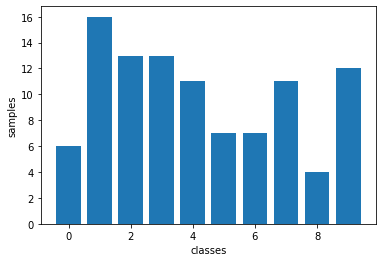

In [ ]:
dist = dict(Counter(train_data.targets))
plt.bar(dist.keys(), dist.values())
plt.xlabel('classes')
plt.ylabel('samples')

As we can see in this barplot the data is small and not balanced, class 8 for example has only 4 samples.

## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The training procedure is difficult in this case because the dataset is very small which makes the model very prone to overfitting. In fact the model becomes very specific to the few samples present in the training set and doesn't generalize well to unseen data. Some possible solutions are:

* Data augmentation: to increase the number and variety of training samples.
* Transfer Learning: we use a model that was pre-trained on very large datasets such as ImageNet and the fine-tune it on our small dataset, it will have better generalization capacities.
* Use early stopping: to stop model before it overfits.
* Ensembling: one can train several models and ensemble their results to get more accurate predictions.
* One can add dropout layers in the network as a regularization technique (5Batch normalization can be used too).

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

**This github repository claims a 93.02% accuracy for a ResNet18 trained on the full CIFAR-10 dataset.**

In [ ]:
# Adapted from: https://github.com/kuangliu/pytorch-cifar

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        block = BasicBlock
        num_blocks = [2,2,2,2]
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# Code from: https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define network, optimizer, loss
net = ResNet18()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= .01, momentum=0.9, weight_decay=5e-4)

In [ ]:
def train(net, epoch, X_train=X_train):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(X_train)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Training, epoch', epoch, 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(len(X_train)), 100.*correct/total, correct, total))

def test(net, epoch, X_test=X_test, return_accuracies = False):
    "test functionfor early stopping"
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    accuracies = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(X_test)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print('Test, epoch', epoch, 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (test_loss/(len(X_test)), 100.*correct/total, correct, total))
    accuracies.append(correct/total)
    
    if return_accuracies:
      return test_loss/len(X_test), accuracies
    else:
      return test_loss/len(X_test)

In [ ]:
for epoch in range(0, 25):
    train(net, epoch)
    test(net, epoch)


Epoch: 0


100%|██████████| 10/10 [00:00<00:00, 58.78it/s]


Training, epoch 0 Loss: 2.755 | Acc: 13.000% (13/100)


100%|██████████| 100/100 [00:04<00:00, 24.15it/s]


Test, epoch 0 Loss: 2.295 | Acc: 12.480% (1248/10000)

Epoch: 1


100%|██████████| 10/10 [00:00<00:00, 63.36it/s]


Training, epoch 1 Loss: 2.774 | Acc: 20.000% (20/100)


100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Test, epoch 1 Loss: 8.742 | Acc: 13.370% (1337/10000)

Epoch: 2


100%|██████████| 10/10 [00:00<00:00, 60.51it/s]


Training, epoch 2 Loss: 3.112 | Acc: 20.000% (20/100)


100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Test, epoch 2 Loss: 11.250 | Acc: 12.150% (1215/10000)

Epoch: 3


100%|██████████| 10/10 [00:00<00:00, 61.52it/s]


Training, epoch 3 Loss: 2.583 | Acc: 27.000% (27/100)


100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Test, epoch 3 Loss: 5.216 | Acc: 16.070% (1607/10000)

Epoch: 4


100%|██████████| 10/10 [00:00<00:00, 61.61it/s]


Training, epoch 4 Loss: 2.659 | Acc: 32.000% (32/100)


100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


Test, epoch 4 Loss: 7.581 | Acc: 15.380% (1538/10000)

Epoch: 5


100%|██████████| 10/10 [00:00<00:00, 61.44it/s]


Training, epoch 5 Loss: 2.206 | Acc: 34.000% (34/100)


100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Test, epoch 5 Loss: 4.863 | Acc: 13.530% (1353/10000)

Epoch: 6


100%|██████████| 10/10 [00:00<00:00, 62.31it/s]


Training, epoch 6 Loss: 1.622 | Acc: 45.000% (45/100)


100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Test, epoch 6 Loss: 4.171 | Acc: 17.360% (1736/10000)

Epoch: 7


100%|██████████| 10/10 [00:00<00:00, 60.87it/s]


Training, epoch 7 Loss: 1.415 | Acc: 52.000% (52/100)


100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Test, epoch 7 Loss: 3.309 | Acc: 20.260% (2026/10000)

Epoch: 8


100%|██████████| 10/10 [00:00<00:00, 58.27it/s]


Training, epoch 8 Loss: 1.183 | Acc: 64.000% (64/100)


100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


Test, epoch 8 Loss: 3.659 | Acc: 21.680% (2168/10000)

Epoch: 9


100%|██████████| 10/10 [00:00<00:00, 59.57it/s]


Training, epoch 9 Loss: 1.055 | Acc: 65.000% (65/100)


100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


Test, epoch 9 Loss: 4.047 | Acc: 20.140% (2014/10000)

Epoch: 10


100%|██████████| 10/10 [00:00<00:00, 60.41it/s]


Training, epoch 10 Loss: 1.145 | Acc: 69.000% (69/100)


100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


Test, epoch 10 Loss: 4.405 | Acc: 18.950% (1895/10000)

Epoch: 11


100%|██████████| 10/10 [00:00<00:00, 60.36it/s]


Training, epoch 11 Loss: 0.942 | Acc: 71.000% (71/100)


100%|██████████| 100/100 [00:04<00:00, 24.25it/s]


Test, epoch 11 Loss: 4.676 | Acc: 20.380% (2038/10000)

Epoch: 12


100%|██████████| 10/10 [00:00<00:00, 59.50it/s]


Training, epoch 12 Loss: 0.737 | Acc: 76.000% (76/100)


100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


Test, epoch 12 Loss: 4.060 | Acc: 22.440% (2244/10000)

Epoch: 13


100%|██████████| 10/10 [00:00<00:00, 57.40it/s]


Training, epoch 13 Loss: 0.420 | Acc: 87.000% (87/100)


100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


Test, epoch 13 Loss: 4.219 | Acc: 23.760% (2376/10000)

Epoch: 14


100%|██████████| 10/10 [00:00<00:00, 58.49it/s]


Training, epoch 14 Loss: 0.200 | Acc: 95.000% (95/100)


100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Test, epoch 14 Loss: 4.666 | Acc: 22.030% (2203/10000)

Epoch: 15


100%|██████████| 10/10 [00:00<00:00, 61.45it/s]


Training, epoch 15 Loss: 0.316 | Acc: 90.000% (90/100)


100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Test, epoch 15 Loss: 4.800 | Acc: 21.280% (2128/10000)

Epoch: 16


100%|██████████| 10/10 [00:00<00:00, 62.09it/s]


Training, epoch 16 Loss: 0.331 | Acc: 92.000% (92/100)


100%|██████████| 100/100 [00:04<00:00, 24.50it/s]


Test, epoch 16 Loss: 4.836 | Acc: 21.950% (2195/10000)

Epoch: 17


100%|██████████| 10/10 [00:00<00:00, 63.40it/s]


Training, epoch 17 Loss: 0.234 | Acc: 92.000% (92/100)


100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Test, epoch 17 Loss: 4.631 | Acc: 23.100% (2310/10000)

Epoch: 18


100%|██████████| 10/10 [00:00<00:00, 62.35it/s]


Training, epoch 18 Loss: 0.134 | Acc: 96.000% (96/100)


100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Test, epoch 18 Loss: 4.950 | Acc: 22.090% (2209/10000)

Epoch: 19


100%|██████████| 10/10 [00:00<00:00, 58.84it/s]


Training, epoch 19 Loss: 0.193 | Acc: 94.000% (94/100)


100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Test, epoch 19 Loss: 4.957 | Acc: 21.480% (2148/10000)

Epoch: 20


100%|██████████| 10/10 [00:00<00:00, 61.36it/s]


Training, epoch 20 Loss: 0.129 | Acc: 96.000% (96/100)


100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Test, epoch 20 Loss: 4.500 | Acc: 22.900% (2290/10000)

Epoch: 21


100%|██████████| 10/10 [00:00<00:00, 62.30it/s]


Training, epoch 21 Loss: 0.156 | Acc: 93.000% (93/100)


100%|██████████| 100/100 [00:04<00:00, 24.06it/s]


Test, epoch 21 Loss: 4.734 | Acc: 23.120% (2312/10000)

Epoch: 22


100%|██████████| 10/10 [00:00<00:00, 62.61it/s]


Training, epoch 22 Loss: 0.239 | Acc: 95.000% (95/100)


100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Test, epoch 22 Loss: 5.293 | Acc: 19.530% (1953/10000)

Epoch: 23


100%|██████████| 10/10 [00:00<00:00, 61.49it/s]


Training, epoch 23 Loss: 0.097 | Acc: 97.000% (97/100)


100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Test, epoch 23 Loss: 5.653 | Acc: 20.560% (2056/10000)

Epoch: 24


100%|██████████| 10/10 [00:00<00:00, 61.70it/s]


Training, epoch 24 Loss: 0.057 | Acc: 98.000% (98/100)


100%|██████████| 100/100 [00:04<00:00, 24.63it/s]

Test, epoch 24 Loss: 5.402 | Acc: 21.660% (2166/10000)


In [ ]:
for epoch in range(0, 20):
    train(net, epoch)
    test(net, epoch)


Epoch: 0


100%|██████████| 10/10 [00:00<00:00, 60.23it/s]


Training, epoch 0 Loss: 2.887 | Acc: 21.000% (21/100)


100%|██████████| 1000/1000 [00:06<00:00, 157.66it/s]


Test, epoch 0 Loss: 2.249 | Acc: 14.200% (1420/10000)

Epoch: 1


100%|██████████| 10/10 [00:00<00:00, 60.41it/s]


Training, epoch 1 Loss: 3.067 | Acc: 16.000% (16/100)


100%|██████████| 1000/1000 [00:06<00:00, 152.09it/s]


Test, epoch 1 Loss: 92.125 | Acc: 13.120% (1312/10000)

Epoch: 2


100%|██████████| 10/10 [00:00<00:00, 65.14it/s]


Training, epoch 2 Loss: 2.977 | Acc: 16.000% (16/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.96it/s]


Test, epoch 2 Loss: 14.831 | Acc: 15.240% (1524/10000)

Epoch: 3


100%|██████████| 10/10 [00:00<00:00, 65.74it/s]


Training, epoch 3 Loss: 2.317 | Acc: 27.000% (27/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.27it/s]


Test, epoch 3 Loss: 5.748 | Acc: 16.510% (1651/10000)

Epoch: 4


100%|██████████| 10/10 [00:00<00:00, 63.14it/s]


Training, epoch 4 Loss: 2.009 | Acc: 38.000% (38/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.25it/s]


Test, epoch 4 Loss: 3.787 | Acc: 17.080% (1708/10000)

Epoch: 5


100%|██████████| 10/10 [00:00<00:00, 63.16it/s]


Training, epoch 5 Loss: 1.944 | Acc: 33.000% (33/100)


100%|██████████| 1000/1000 [00:05<00:00, 173.00it/s]


Test, epoch 5 Loss: 5.722 | Acc: 17.430% (1743/10000)

Epoch: 6


100%|██████████| 10/10 [00:00<00:00, 63.30it/s]


Training, epoch 6 Loss: 1.715 | Acc: 36.000% (36/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.70it/s]


Test, epoch 6 Loss: 2.687 | Acc: 16.290% (1629/10000)

Epoch: 7


100%|██████████| 10/10 [00:00<00:00, 63.60it/s]


Training, epoch 7 Loss: 1.370 | Acc: 54.000% (54/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.97it/s]


Test, epoch 7 Loss: 2.873 | Acc: 19.040% (1904/10000)

Epoch: 8


100%|██████████| 10/10 [00:00<00:00, 63.84it/s]


Training, epoch 8 Loss: 1.430 | Acc: 50.000% (50/100)


100%|██████████| 1000/1000 [00:06<00:00, 151.84it/s]


Test, epoch 8 Loss: 3.050 | Acc: 17.760% (1776/10000)

Epoch: 9


100%|██████████| 10/10 [00:00<00:00, 63.36it/s]


Training, epoch 9 Loss: 1.455 | Acc: 52.000% (52/100)


100%|██████████| 1000/1000 [00:05<00:00, 171.62it/s]


Test, epoch 9 Loss: 3.579 | Acc: 22.190% (2219/10000)

Epoch: 10


100%|██████████| 10/10 [00:00<00:00, 63.85it/s]


Training, epoch 10 Loss: 1.433 | Acc: 56.000% (56/100)


100%|██████████| 1000/1000 [00:05<00:00, 173.13it/s]


Test, epoch 10 Loss: 3.559 | Acc: 19.350% (1935/10000)

Epoch: 11


100%|██████████| 10/10 [00:00<00:00, 64.37it/s]


Training, epoch 11 Loss: 1.065 | Acc: 66.000% (66/100)


100%|██████████| 1000/1000 [00:05<00:00, 171.21it/s]


Test, epoch 11 Loss: 3.608 | Acc: 21.380% (2138/10000)

Epoch: 12


100%|██████████| 10/10 [00:00<00:00, 63.55it/s]


Training, epoch 12 Loss: 1.105 | Acc: 67.000% (67/100)


100%|██████████| 1000/1000 [00:07<00:00, 141.99it/s]


Test, epoch 12 Loss: 3.503 | Acc: 19.720% (1972/10000)

Epoch: 13


100%|██████████| 10/10 [00:00<00:00, 63.60it/s]


Training, epoch 13 Loss: 0.858 | Acc: 66.000% (66/100)


100%|██████████| 1000/1000 [00:05<00:00, 173.29it/s]


Test, epoch 13 Loss: 4.449 | Acc: 21.320% (2132/10000)

Epoch: 14


100%|██████████| 10/10 [00:00<00:00, 65.04it/s]


Training, epoch 14 Loss: 0.633 | Acc: 74.000% (74/100)


100%|██████████| 1000/1000 [00:06<00:00, 158.73it/s]


Test, epoch 14 Loss: 4.015 | Acc: 20.010% (2001/10000)

Epoch: 15


100%|██████████| 10/10 [00:00<00:00, 63.49it/s]


Training, epoch 15 Loss: 0.664 | Acc: 80.000% (80/100)


100%|██████████| 1000/1000 [00:06<00:00, 162.92it/s]


Test, epoch 15 Loss: 6.146 | Acc: 19.290% (1929/10000)

Epoch: 16


100%|██████████| 10/10 [00:00<00:00, 62.69it/s]


Training, epoch 16 Loss: 0.717 | Acc: 76.000% (76/100)


100%|██████████| 1000/1000 [00:05<00:00, 171.22it/s]


Test, epoch 16 Loss: 4.266 | Acc: 20.070% (2007/10000)

Epoch: 17


100%|██████████| 10/10 [00:00<00:00, 62.76it/s]


Training, epoch 17 Loss: 0.848 | Acc: 82.000% (82/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.03it/s]


Test, epoch 17 Loss: 4.264 | Acc: 20.580% (2058/10000)

Epoch: 18


100%|██████████| 10/10 [00:00<00:00, 64.90it/s]


Training, epoch 18 Loss: 0.482 | Acc: 85.000% (85/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.18it/s]


Test, epoch 18 Loss: 4.211 | Acc: 19.920% (1992/10000)

Epoch: 19


100%|██████████| 10/10 [00:00<00:00, 66.61it/s]


Training, epoch 19 Loss: 0.381 | Acc: 89.000% (89/100)


100%|██████████| 1000/1000 [00:05<00:00, 172.17it/s]

Test, epoch 19 Loss: 8.999 | Acc: 18.720% (1872/10000)


### Results
Here we report the results of the epoch with the best test accuracy

| Model | Number of  epochs  | Train accuracy | Test accuracy | Full data accuracy|
|------|------|------|------|------|
|   Resnet18(from scratch)  | 20 | 52% | 22.19% |93.02%*|

*with data augmentation, source: https://github.com/kuangliu/pytorch-cifar

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
class Resnet_model(nn.Module):

    def __init__(self, freeze=True, nclasses=10):
        super(Resnet_model, self).__init__()

        pretrained_resnet = models.resnet18(pretrained=True)
        num_features = pretrained_resnet.fc.in_features

        self.resnet_layer =  torch.nn.Sequential(*list(pretrained_resnet.children())[:-1])

        # freeze resnet layers and only train the classification layer 
        if freeze:
            for p in self.resnet_layer.parameters():
                p.requires_grad = False

        # classification layer
        self.fc = nn.Linear(num_features, nclasses)

    def forward(self, x):
        out = self.resnet_layer(x)
        out = out.view(x.shape[0],-1)
        out = self.fc(out)
        return out

In [ ]:
pretrained_net = Resnet_model(freeze=False)
pretrained_net = pretrained_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_net .parameters(), lr= .01, momentum=0.7, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
early_stopping = EarlyStopping(patience=6, min_delta=0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

This model was pretrained on ImageNet images, which had bigger size and used a different normalization parameters, therefore we will resize our images and change their normalization to make the best out of the pre-training.

In [ ]:
# Resize and normalize to fit ImageNet dataset
transform_transfer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    transforms.Resize(224),
    ])

test_data2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform_transfer)
train_data2 = Cifar_100_samples(cifar_data, transform = transform_transfer)

X_train2 = torch.utils.data.DataLoader(train_data2, batch_size=10, shuffle=True)
X_test2 = torch.utils.data.DataLoader(test_data2, batch_size=256, shuffle=True)

Files already downloaded and verified


In [ ]:
# Check shape of transformed dataset
next(iter(X_train2))[0].shape

torch.Size([10, 3, 224, 224])

We will fine-tune only the last layer for classification

In [ ]:
criterion = nn.CrossEntropyLoss()
pretrained_net = Resnet_model(freeze=True)
pretrained_net = pretrained_net.to(device)

optimizer = optim.SGD(pretrained_net.parameters(), lr= .01, momentum=0.7, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
early_stopping = EarlyStopping(patience=5, min_delta=0)

In [ ]:
for epoch in range(0, 25):
    train(pretrained_net, epoch, X_train2)
    test(pretrained_net, epoch, X_test2)


Epoch: 0


100%|██████████| 10/10 [00:00<00:00, 43.01it/s]


Training, epoch 0 Loss: 2.497 | Acc: 15.000% (15/100)


100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Test, epoch 0 Loss: 2.209 | Acc: 27.770% (2777/10000)

Epoch: 1


100%|██████████| 10/10 [00:00<00:00, 43.93it/s]


Training, epoch 1 Loss: 1.829 | Acc: 38.000% (38/100)


100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Test, epoch 1 Loss: 2.135 | Acc: 23.330% (2333/10000)

Epoch: 2


100%|██████████| 10/10 [00:00<00:00, 45.77it/s]


Training, epoch 2 Loss: 1.584 | Acc: 41.000% (41/100)


100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Test, epoch 2 Loss: 1.896 | Acc: 33.740% (3374/10000)

Epoch: 3


100%|██████████| 10/10 [00:00<00:00, 46.59it/s]


Training, epoch 3 Loss: 1.074 | Acc: 65.000% (65/100)


100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Test, epoch 3 Loss: 1.547 | Acc: 47.900% (4790/10000)

Epoch: 4


100%|██████████| 10/10 [00:00<00:00, 45.77it/s]


Training, epoch 4 Loss: 0.896 | Acc: 79.000% (79/100)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Test, epoch 4 Loss: 1.496 | Acc: 48.100% (4810/10000)

Epoch: 5


100%|██████████| 10/10 [00:00<00:00, 45.20it/s]


Training, epoch 5 Loss: 0.677 | Acc: 82.000% (82/100)


100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Test, epoch 5 Loss: 1.425 | Acc: 50.350% (5035/10000)

Epoch: 6


100%|██████████| 10/10 [00:00<00:00, 45.94it/s]


Training, epoch 6 Loss: 0.631 | Acc: 83.000% (83/100)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Test, epoch 6 Loss: 1.320 | Acc: 54.510% (5451/10000)

Epoch: 7


100%|██████████| 10/10 [00:00<00:00, 46.77it/s]


Training, epoch 7 Loss: 0.395 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Test, epoch 7 Loss: 1.499 | Acc: 46.960% (4696/10000)

Epoch: 8


100%|██████████| 10/10 [00:00<00:00, 47.30it/s]


Training, epoch 8 Loss: 0.429 | Acc: 90.000% (90/100)


100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Test, epoch 8 Loss: 1.434 | Acc: 49.660% (4966/10000)

Epoch: 9


100%|██████████| 10/10 [00:00<00:00, 47.55it/s]


Training, epoch 9 Loss: 0.427 | Acc: 90.000% (90/100)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Test, epoch 9 Loss: 1.415 | Acc: 51.460% (5146/10000)

Epoch: 10


100%|██████████| 10/10 [00:00<00:00, 45.09it/s]


Training, epoch 10 Loss: 0.340 | Acc: 95.000% (95/100)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Test, epoch 10 Loss: 1.474 | Acc: 49.350% (4935/10000)

Epoch: 11


100%|██████████| 10/10 [00:00<00:00, 46.71it/s]


Training, epoch 11 Loss: 0.245 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:19<00:00,  2.00it/s]


Test, epoch 11 Loss: 1.364 | Acc: 52.770% (5277/10000)

Epoch: 12


100%|██████████| 10/10 [00:00<00:00, 46.47it/s]


Training, epoch 12 Loss: 0.211 | Acc: 98.000% (98/100)


100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Test, epoch 12 Loss: 1.302 | Acc: 55.300% (5530/10000)

Epoch: 13


100%|██████████| 10/10 [00:00<00:00, 47.32it/s]


Training, epoch 13 Loss: 0.186 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:19<00:00,  2.00it/s]


Test, epoch 13 Loss: 1.375 | Acc: 52.160% (5216/10000)

Epoch: 14


100%|██████████| 10/10 [00:00<00:00, 45.96it/s]


Training, epoch 14 Loss: 0.221 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Test, epoch 14 Loss: 1.353 | Acc: 52.740% (5274/10000)

Epoch: 15


100%|██████████| 10/10 [00:00<00:00, 46.02it/s]


Training, epoch 15 Loss: 0.274 | Acc: 95.000% (95/100)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Test, epoch 15 Loss: 1.452 | Acc: 50.680% (5068/10000)

Epoch: 16


100%|██████████| 10/10 [00:00<00:00, 45.02it/s]


Training, epoch 16 Loss: 0.143 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Test, epoch 16 Loss: 1.399 | Acc: 51.610% (5161/10000)

Epoch: 17


100%|██████████| 10/10 [00:00<00:00, 46.20it/s]


Training, epoch 17 Loss: 0.175 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Test, epoch 17 Loss: 1.414 | Acc: 51.210% (5121/10000)

Epoch: 18


100%|██████████| 10/10 [00:00<00:00, 46.12it/s]


Training, epoch 18 Loss: 0.174 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Test, epoch 18 Loss: 1.341 | Acc: 53.960% (5396/10000)

Epoch: 19


100%|██████████| 10/10 [00:00<00:00, 46.71it/s]


Training, epoch 19 Loss: 0.152 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Test, epoch 19 Loss: 1.352 | Acc: 53.470% (5347/10000)

Epoch: 20


100%|██████████| 10/10 [00:00<00:00, 45.97it/s]


Training, epoch 20 Loss: 0.129 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Test, epoch 20 Loss: 1.300 | Acc: 55.260% (5526/10000)

Epoch: 21


100%|██████████| 10/10 [00:00<00:00, 46.37it/s]


Training, epoch 21 Loss: 0.180 | Acc: 98.000% (98/100)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Test, epoch 21 Loss: 1.437 | Acc: 51.600% (5160/10000)

Epoch: 22


100%|██████████| 10/10 [00:00<00:00, 47.13it/s]


Training, epoch 22 Loss: 0.140 | Acc: 98.000% (98/100)


100%|██████████| 40/40 [00:19<00:00,  2.00it/s]


Test, epoch 22 Loss: 1.328 | Acc: 53.970% (5397/10000)

Epoch: 23


100%|██████████| 10/10 [00:00<00:00, 46.54it/s]


Training, epoch 23 Loss: 0.137 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Test, epoch 23 Loss: 1.365 | Acc: 52.740% (5274/10000)

Epoch: 24


100%|██████████| 10/10 [00:00<00:00, 47.18it/s]


Training, epoch 24 Loss: 0.165 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:20<00:00,  1.99it/s]

Test, epoch 24 Loss: 1.348 | Acc: 54.300% (5430/10000)


Let's fine-tune all layers

In [ ]:
pretrained_net = Resnet_model(freeze=False)
pretrained_net = pretrained_net.to(device)

optimizer = optim.SGD(pretrained_net.parameters(), lr= .01, momentum=0.7, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [ ]:
for epoch in range(0, 25):
    train(pretrained_net, epoch, X_train2)
    test(pretrained_net, epoch, X_test2)


Epoch: 0


100%|██████████| 10/10 [00:00<00:00, 26.21it/s]


Training, epoch 0 Loss: 2.468 | Acc: 15.000% (15/100)


100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Test, epoch 0 Loss: 2.206 | Acc: 23.840% (2384/10000)

Epoch: 1


100%|██████████| 10/10 [00:00<00:00, 27.20it/s]


Training, epoch 1 Loss: 1.260 | Acc: 62.000% (62/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 1 Loss: 2.471 | Acc: 19.030% (1903/10000)

Epoch: 2


100%|██████████| 10/10 [00:00<00:00, 27.86it/s]


Training, epoch 2 Loss: 0.666 | Acc: 79.000% (79/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 2 Loss: 1.589 | Acc: 44.820% (4482/10000)

Epoch: 3


100%|██████████| 10/10 [00:00<00:00, 27.33it/s]


Training, epoch 3 Loss: 0.183 | Acc: 99.000% (99/100)


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Test, epoch 3 Loss: 1.530 | Acc: 46.070% (4607/10000)

Epoch: 4


100%|██████████| 10/10 [00:00<00:00, 27.70it/s]


Training, epoch 4 Loss: 0.074 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 4 Loss: 1.500 | Acc: 48.610% (4861/10000)

Epoch: 5


100%|██████████| 10/10 [00:00<00:00, 27.36it/s]


Training, epoch 5 Loss: 0.034 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 5 Loss: 1.503 | Acc: 49.700% (4970/10000)

Epoch: 6


100%|██████████| 10/10 [00:00<00:00, 27.58it/s]


Training, epoch 6 Loss: 0.028 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 6 Loss: 1.470 | Acc: 50.210% (5021/10000)

Epoch: 7


100%|██████████| 10/10 [00:00<00:00, 26.72it/s]


Training, epoch 7 Loss: 0.031 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 7 Loss: 1.473 | Acc: 49.970% (4997/10000)

Epoch: 8


100%|██████████| 10/10 [00:00<00:00, 27.53it/s]


Training, epoch 8 Loss: 0.029 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 8 Loss: 1.506 | Acc: 49.720% (4972/10000)

Epoch: 9


100%|██████████| 10/10 [00:00<00:00, 27.71it/s]


Training, epoch 9 Loss: 0.025 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 9 Loss: 1.484 | Acc: 50.220% (5022/10000)

Epoch: 10


100%|██████████| 10/10 [00:00<00:00, 27.72it/s]


Training, epoch 10 Loss: 0.013 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 10 Loss: 1.476 | Acc: 51.250% (5125/10000)

Epoch: 11


100%|██████████| 10/10 [00:00<00:00, 27.62it/s]


Training, epoch 11 Loss: 0.016 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 11 Loss: 1.430 | Acc: 51.890% (5189/10000)

Epoch: 12


100%|██████████| 10/10 [00:00<00:00, 27.67it/s]


Training, epoch 12 Loss: 0.013 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 12 Loss: 1.452 | Acc: 51.500% (5150/10000)

Epoch: 13


100%|██████████| 10/10 [00:00<00:00, 27.41it/s]


Training, epoch 13 Loss: 0.022 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 13 Loss: 1.525 | Acc: 49.680% (4968/10000)

Epoch: 14


100%|██████████| 10/10 [00:00<00:00, 26.82it/s]


Training, epoch 14 Loss: 0.016 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 14 Loss: 1.498 | Acc: 50.100% (5010/10000)

Epoch: 15


100%|██████████| 10/10 [00:00<00:00, 27.44it/s]


Training, epoch 15 Loss: 0.012 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 15 Loss: 1.494 | Acc: 50.710% (5071/10000)

Epoch: 16


100%|██████████| 10/10 [00:00<00:00, 27.46it/s]


Training, epoch 16 Loss: 0.011 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 16 Loss: 1.523 | Acc: 50.420% (5042/10000)

Epoch: 17


100%|██████████| 10/10 [00:00<00:00, 27.49it/s]


Training, epoch 17 Loss: 0.007 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 17 Loss: 1.540 | Acc: 50.550% (5055/10000)

Epoch: 18


100%|██████████| 10/10 [00:00<00:00, 27.90it/s]


Training, epoch 18 Loss: 0.014 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 18 Loss: 1.491 | Acc: 51.620% (5162/10000)

Epoch: 19


100%|██████████| 10/10 [00:00<00:00, 27.51it/s]


Training, epoch 19 Loss: 0.010 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Test, epoch 19 Loss: 1.490 | Acc: 51.420% (5142/10000)

Epoch: 20


100%|██████████| 10/10 [00:00<00:00, 27.85it/s]


Training, epoch 20 Loss: 0.008 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 20 Loss: 1.477 | Acc: 51.530% (5153/10000)

Epoch: 21


100%|██████████| 10/10 [00:00<00:00, 27.28it/s]


Training, epoch 21 Loss: 0.006 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 21 Loss: 1.473 | Acc: 51.940% (5194/10000)

Epoch: 22


100%|██████████| 10/10 [00:00<00:00, 26.40it/s]


Training, epoch 22 Loss: 0.006 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Test, epoch 22 Loss: 1.465 | Acc: 52.180% (5218/10000)

Epoch: 23


100%|██████████| 10/10 [00:00<00:00, 26.96it/s]


Training, epoch 23 Loss: 0.019 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Test, epoch 23 Loss: 1.544 | Acc: 50.230% (5023/10000)

Epoch: 24


100%|██████████| 10/10 [00:00<00:00, 27.56it/s]


Training, epoch 24 Loss: 0.008 | Acc: 100.000% (100/100)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

Test, epoch 24 Loss: 1.509 | Acc: 51.180% (5118/10000)


### Results

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18(fine-tuning last layer)  | 25 | 100% | 55.72% |
|   Resnet18(fine-tuning all layers)  | 25 | 100% | 52.18% |

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

Dealing with such transformations on low-resolution images may be troublesome. Indeed, the geometric transformations (translations, rotations, scaling, perspectives) rely on (nearest neighbor or bilinear) interpolations. For instance, according to the PyTorch documentation, each point $x'$ of the rotated image is first mapped to its corresponding point $x$ in the original image, then the image value at $x$ is estimated by the color of the nearest neighbor. Finally this value is assigned to $x'$.
Using these interpolations on coarse images can result to high approximation errors as the image intensity can change abruptly. 

One solution could be to increase the image resolution before applying these transformations. 

## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

In [ ]:
# Data augmentation, we use the same as https://github.com/kuangliu/pytorch-cifar/

transform_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(30),
    #transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data_augment = Cifar_100_samples(cifar_data, transform = transform_augment)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform_test)

X_train_augment = torch.utils.data.DataLoader(train_data_augment , batch_size=10, shuffle=True)
X_test = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss()
net = ResNet18()
net = net.to(device)

optimizer = optim.SGD(net.parameters(), lr= .01, momentum=0.7, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [ ]:
# Augmentation on baseline model
for epoch in range(0, 25):
    train(net, epoch, X_train_augment)
    test_loss = test(net, epoch, X_test)
    scheduler.step()


Epoch: 0


100%|██████████| 10/10 [00:00<00:00, 54.87it/s]


Training, epoch 0 Loss: 2.472 | Acc: 14.000% (14/100)


100%|██████████| 100/100 [00:04<00:00, 21.19it/s]


Test, epoch 0 Loss: 2.360 | Acc: 10.000% (1000/10000)

Epoch: 1


100%|██████████| 10/10 [00:00<00:00, 56.57it/s]


Training, epoch 1 Loss: 2.518 | Acc: 18.000% (18/100)


100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Test, epoch 1 Loss: 2.484 | Acc: 12.670% (1267/10000)

Epoch: 2


100%|██████████| 10/10 [00:00<00:00, 54.62it/s]


Training, epoch 2 Loss: 2.340 | Acc: 23.000% (23/100)


100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Test, epoch 2 Loss: 3.050 | Acc: 13.190% (1319/10000)

Epoch: 3


100%|██████████| 10/10 [00:00<00:00, 56.10it/s]


Training, epoch 3 Loss: 2.323 | Acc: 28.000% (28/100)


100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Test, epoch 3 Loss: 5.420 | Acc: 15.920% (1592/10000)

Epoch: 4


100%|██████████| 10/10 [00:00<00:00, 56.66it/s]


Training, epoch 4 Loss: 2.285 | Acc: 25.000% (25/100)


100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Test, epoch 4 Loss: 4.022 | Acc: 16.760% (1676/10000)

Epoch: 5


100%|██████████| 10/10 [00:00<00:00, 54.25it/s]


Training, epoch 5 Loss: 1.910 | Acc: 35.000% (35/100)


100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


Test, epoch 5 Loss: 2.385 | Acc: 22.490% (2249/10000)

Epoch: 6


100%|██████████| 10/10 [00:00<00:00, 54.29it/s]


Training, epoch 6 Loss: 1.413 | Acc: 53.000% (53/100)


100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Test, epoch 6 Loss: 2.466 | Acc: 22.640% (2264/10000)

Epoch: 7


100%|██████████| 10/10 [00:00<00:00, 55.56it/s]


Training, epoch 7 Loss: 1.427 | Acc: 51.000% (51/100)


100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


Test, epoch 7 Loss: 2.493 | Acc: 23.140% (2314/10000)

Epoch: 8


100%|██████████| 10/10 [00:00<00:00, 57.38it/s]


Training, epoch 8 Loss: 1.383 | Acc: 47.000% (47/100)


100%|██████████| 100/100 [00:03<00:00, 25.44it/s]


Test, epoch 8 Loss: 2.579 | Acc: 23.830% (2383/10000)

Epoch: 9


100%|██████████| 10/10 [00:00<00:00, 56.23it/s]


Training, epoch 9 Loss: 1.279 | Acc: 53.000% (53/100)


100%|██████████| 100/100 [00:03<00:00, 25.44it/s]


Test, epoch 9 Loss: 2.584 | Acc: 24.030% (2403/10000)

Epoch: 10


100%|██████████| 10/10 [00:00<00:00, 54.81it/s]


Training, epoch 10 Loss: 1.167 | Acc: 58.000% (58/100)


100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Test, epoch 10 Loss: 2.557 | Acc: 25.160% (2516/10000)

Epoch: 11


100%|██████████| 10/10 [00:00<00:00, 55.03it/s]


Training, epoch 11 Loss: 1.194 | Acc: 56.000% (56/100)


100%|██████████| 100/100 [00:03<00:00, 25.44it/s]


Test, epoch 11 Loss: 2.548 | Acc: 25.210% (2521/10000)

Epoch: 12


100%|██████████| 10/10 [00:00<00:00, 56.69it/s]


Training, epoch 12 Loss: 1.155 | Acc: 61.000% (61/100)


100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Test, epoch 12 Loss: 2.523 | Acc: 25.130% (2513/10000)

Epoch: 13


100%|██████████| 10/10 [00:00<00:00, 55.65it/s]


Training, epoch 13 Loss: 1.213 | Acc: 58.000% (58/100)


100%|██████████| 100/100 [00:03<00:00, 25.52it/s]


Test, epoch 13 Loss: 2.524 | Acc: 25.530% (2553/10000)

Epoch: 14


100%|██████████| 10/10 [00:00<00:00, 56.16it/s]


Training, epoch 14 Loss: 1.227 | Acc: 53.000% (53/100)


100%|██████████| 100/100 [00:03<00:00, 25.44it/s]


Test, epoch 14 Loss: 2.527 | Acc: 25.100% (2510/10000)

Epoch: 15


100%|██████████| 10/10 [00:00<00:00, 55.27it/s]


Training, epoch 15 Loss: 1.076 | Acc: 59.000% (59/100)


100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


Test, epoch 15 Loss: 2.523 | Acc: 25.460% (2546/10000)

Epoch: 16


100%|██████████| 10/10 [00:00<00:00, 55.48it/s]


Training, epoch 16 Loss: 1.089 | Acc: 63.000% (63/100)


100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Test, epoch 16 Loss: 2.523 | Acc: 25.630% (2563/10000)

Epoch: 17


100%|██████████| 10/10 [00:00<00:00, 55.77it/s]


Training, epoch 17 Loss: 1.077 | Acc: 57.000% (57/100)


100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


Test, epoch 17 Loss: 2.533 | Acc: 25.510% (2551/10000)

Epoch: 18


100%|██████████| 10/10 [00:00<00:00, 54.63it/s]


Training, epoch 18 Loss: 1.155 | Acc: 55.000% (55/100)


100%|██████████| 100/100 [00:03<00:00, 25.25it/s]


Test, epoch 18 Loss: 2.527 | Acc: 25.660% (2566/10000)

Epoch: 19


100%|██████████| 10/10 [00:00<00:00, 55.90it/s]


Training, epoch 19 Loss: 1.150 | Acc: 62.000% (62/100)


100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


Test, epoch 19 Loss: 2.535 | Acc: 25.700% (2570/10000)

Epoch: 20


100%|██████████| 10/10 [00:00<00:00, 54.84it/s]


Training, epoch 20 Loss: 1.187 | Acc: 62.000% (62/100)


100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Test, epoch 20 Loss: 2.537 | Acc: 25.950% (2595/10000)

Epoch: 21


100%|██████████| 10/10 [00:00<00:00, 54.83it/s]


Training, epoch 21 Loss: 1.101 | Acc: 63.000% (63/100)


100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Test, epoch 21 Loss: 2.542 | Acc: 25.690% (2569/10000)

Epoch: 22


100%|██████████| 10/10 [00:00<00:00, 55.19it/s]


Training, epoch 22 Loss: 1.095 | Acc: 65.000% (65/100)


100%|██████████| 100/100 [00:03<00:00, 25.60it/s]


Test, epoch 22 Loss: 2.535 | Acc: 25.770% (2577/10000)

Epoch: 23


100%|██████████| 10/10 [00:00<00:00, 53.69it/s]


Training, epoch 23 Loss: 1.094 | Acc: 58.000% (58/100)


100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


Test, epoch 23 Loss: 2.539 | Acc: 25.620% (2562/10000)

Epoch: 24


100%|██████████| 10/10 [00:00<00:00, 55.76it/s]


Training, epoch 24 Loss: 1.081 | Acc: 66.000% (66/100)


100%|██████████| 100/100 [00:03<00:00, 25.51it/s]

Test, epoch 24 Loss: 2.542 | Acc: 25.700% (2570/10000)


### Results

| Model | Number of  epochs  | Train accuracy | Test accuracy |Full data accuracy|
|------|------|------|------|------|
|   Resnet18 (from scratch with data augmentation)  | 25 | 62% | 25.95% |93.02%|



# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

The table below summarizes the results of the different approaches we tested. The semi-supervised Resnet is described in the following section.

| Model | Number of  epochs  | Train accuracy | Test accuracy |Full data accuracy |
|------|------|------|------|------|
|   Resnet18(from scratch)  | 20 | 52% | 22.19% |----|
|   Resnet18 (from scratch with data augmentation)  | 25 | 62% | 25.95% |93.02%|
|   Resnet18(Pretrained, fine-tuning last layer)  | 25 | **100%** | **55.72%** |----|
|   Resnet18(Pretrained, fine-tuning all layers)  | 25 | 100% | 52.18% |----|
|   Resnet18(semi-supervised)  | 100 | 100% | 30.70% |----|

* **Baseline Resnet18**:<br>
Our baseline model consisted of a Resnet18 model, that we trained from scratch. It is a CNN that uses residual connections, this family of models proved to be powerful for computer vision tasks. This model is made of 18 layers, which gives a good trade-off between performance and computational cost. However, training this model from scratch on 100 samples leads to overfitting and bad generalization on the test set. In fact, after 10 epochs the training accuracy keeps increasing over 80% but the test accuracy reaches a maximum of 22%.

* **Pretrained Resnet18**:<br>
We tested transfer learning, where we used again a Resnet18 net that was pretrained on ImageNet data, to compare to the the baseline using the same model. This approach proved to be more powerful, giving a test accuracy of 55.72% which was an improvement of almost 30% compared to the trained-from-scratch model. Thanks to the pretraining on large data, the model has already learned a wide range of image features, which can not be done using only the 100 samples that we have in the training, so this model overfits less. We tried fine-tuning more than the last layer but the performance didn't improve. However the fine-tuning can be tricky: we had to resize the images, resp. normalize the data to the shape, resp the mean and standard deviation of the of ImageNet images, on which the pretrained model was trained. The choice of the optimization parameters as well as the scheduler where also important.

* **Training Resnet18 from scratch with data augmentation**:<br>
We used data augmentation techniques to increase the amount and variety of the training samples. 
We designed a chain of geometric transformations. The standard PyTorch Transforms tools were used and the transformation randomly applied with a 0.5 probability.  We considered random rotations and perspectives, horizontal and vertical flips. But we got the best results using similar augmentation as in the repository https://github.com/kuangliu/pytorch-cifar, which consist in a  random crop and horizontal flip, which imitates the diversity of camera plans and the symetries found in natural images. Finally, the images were normalized by substracting the channel-wise mean value and dividing by the corresponding standard deviation. 

* **Semi-supervised Resnet18 (bonus question)**:<br>
We tested a semi-supervised approach that makes use of both labeled and unlabeled images. It jointly trains the model on a supervised task of finding classes of labeled images and finding the transformations applied to unlabeled images in a self-supervised setting. This technique performs better than the training from scratch with data augmentation but is still far from the transfer learning approach. However, the results can still be improved with more tuning of the hyperparameters. And since we use more data, the training takes more time in this case.

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In this section, we will use a semi-supervised method for image classification that uses both labeled and unlabeled images during the training. We used the code from a notebook implemented in this blog https://towardsdatascience.com/semi-supervised-learning-demystified-with-pytorch-and-sesemi-9656c14af031 for using SESEMI method of this paper [Exploring Self-Supervised Regularization for Supervised and Semi-Supervised Learning](https://arxiv.org/pdf/1906.10343.pdf) in pytorch. 

The idea of this approach is to train a CNN with two heads giving two losses which are trained jointly, one related to the supervised task of predicting the class of labeled images, and one related to the unlabeled images, to which a transformation (rotation, flip..) is applied and the model has to predict it in a self-supervised setting. In the paper, the authors show that their approach outperforms the fine-tuning of some supervised CNNs on CIFAR-10, but they didn't test it on Resnet18.

Here, we use a resnet18, with the pretraining weights of the supervised setting on ImageNet, and we retrain the whole new model on the semi-supervised task.



In [ ]:
import random
from typing import Optional
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SesemiTransform:
    """
    Torchvision-style transform to apply SESEMI augmentation to image.
    """

    classes = ('0', '90', '180', '270', 'hflip', 'vflip')

    def __call__(self, x):
        tf_type = random.randint(0, len(self.classes) - 1)
        if tf_type == 0:
            x = x
        elif tf_type == 1:
            x = transforms.functional.rotate(x, 90)
        elif tf_type == 2:
            x = transforms.functional.rotate(x, 180)
        elif tf_type == 3:
            x = transforms.functional.rotate(x, 270)
        elif tf_type == 4:
            x = transforms.functional.hflip(x)
        elif tf_type == 5:
            x = transforms.functional.rotate(x, 180)
            x = transforms.functional.hflip(x)
        return x, tf_type

class LabeledDataset(Dataset):
    """
    Labeled training Dataset class.
    """

    def __init__(self, data: np.ndarray, labels: list,
            transform: Optional[transforms.Compose] = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> tuple:
        if idx >= len(self):
            raise IndexError(f'{idx} is out-of-bounds for dataset (length: {len(self)})')
        s_idx = idx % len(self.labels)
        
        data = self.data[s_idx]
        labels = self.labels[s_idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, labels

class UnlabeledDataset(Dataset):
    """
    Unlabeled training Dataset class.
    """

    def __init__(self, data: np.ndarray,
            transform: Optional[transforms.Compose] = None):
        self.data = data
        self.transform = transform
        self.sesemi_transform = SesemiTransform()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int) -> np.ndarray:
        data = self.data[idx]
        if self.transform is not None:
            data = self.transform(data)
        data, label = self.sesemi_transform(data)
        return data, label

In [ ]:
batch_size = 12
n_epochs = 25
n_batches_print = 20

### Creating labeled and unlabeled data loaders

In [ ]:
sup_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
labeled_trainset = LabeledDataset(trainset.data[:100], trainset.targets[:100], transform=transform)
unlabeled_trainset = UnlabeledDataset(trainset.data[100:], transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

print(f'Number labaled training samples:   {len(labeled_trainset):6d}')
print(f'Number unlabeled training samples: {len(unlabeled_trainset):6d}')
print(f'Number  testing samples:           {len(testset):6d}')

Files already downloaded and verified
Files already downloaded and verified
Number labaled training samples:      100
Number unlabeled training samples:  49900
Number  testing samples:            10000


In [ ]:
labeled_trainloader = DataLoader(labeled_trainset, batch_size=batch_size,
    shuffle=True, num_workers=2)
unlabeled_trainloader = DataLoader(unlabeled_trainset, batch_size=batch_size,
    shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
    num_workers=2)

In [ ]:
unsup_classes = unlabeled_trainset.sesemi_transform.classes

#### Model training

In [ ]:
class SesemiNet(nn.Module):
    """
    ResNet backbone with two heads for SESEMI training.
    """

    def __init__(
        self,
        n_sup_classes: int,
        n_unsup_classes: int,
        pretrained: bool = True
    ):
        super().__init__()
        self.resnet = torchvision.models.resnet18(pretrained=pretrained)
        self.fc_out = 256
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self.fc_out)
        self.sup_fc = nn.Linear(self.fc_out, n_sup_classes)
        self.selfsup_fc = nn.Linear(self.fc_out, n_unsup_classes)

    def forward(self, x: torch.Tensor, x_selfsup: Optional[torch.Tensor] = None):
        x = self.resnet(x)
        x = self.sup_fc(x)
        if x_selfsup is not None:
            x_selfsup = self.resnet(x_selfsup)
            x_selfsup = self.selfsup_fc(x_selfsup)
            return x, x_selfsup
        else:
            return x

In [ ]:
def train(
    model: nn.Module,
    labeled_trainloader: DataLoader,
    unlabeled_trainloader: Optional[DataLoader] = None,
    valloader: Optional[DataLoader] = None,
    n_epochs: int = 2,
    n_batches_print: int = 1000,
    device: Optional[str] = None,
    unsup_wt: float = 1.0
):
    """
    Execute SESEMI training loop.
    """

    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_losses = []
    val_losses = []
    val_accs = []
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        train_loss_sum = 0.0
        running_loss_sup = 0.0
        running_loss_unsup = 0.0
        dataloaders = zip(labeled_trainloader, [None] * len(labeled_trainloader))\
            if unlabeled_trainloader is None else zip(labeled_trainloader, unlabeled_trainloader)
        for i, (sup_data, unsup_data) in enumerate(dataloaders, start=0):
            optimizer.zero_grad()
            sup_inputs, sup_labels = sup_data
            sup_inputs = sup_inputs.to(device)
            sup_labels = sup_labels.to(device)

            if unsup_data is None:
                sup_outputs = model(sup_inputs)
                loss_unsup = 0.0
            else:
                unsup_inputs, unsup_labels = unsup_data
                unsup_inputs = unsup_inputs.to(device)
                unsup_labels = unsup_labels.to(device)
                # forward pass through model with both data subsets
                sup_outputs, unsup_outputs = model(sup_inputs, x_selfsup=unsup_inputs)
                loss_unsup = unsup_criterion(unsup_outputs, unsup_labels)
                running_loss_unsup += loss_unsup.item()
            loss_sup = sup_criterion(sup_outputs, sup_labels)
            # evaluate loss function
            loss = loss_sup + unsup_wt * loss_unsup
            loss.backward()
            optimizer.step()
            iter_loss = loss_sup.item()
            running_loss_sup += iter_loss
            train_loss_sum += iter_loss

            # print statistics
            if i % n_batches_print == n_batches_print - 1:
                if unsup_data is None:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss (sup): {running_loss_sup / n_batches_print:.4f}')
                else:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss (sup): {running_loss_sup / n_batches_print:.4f} '\
                        f'Train loss (unsup): {running_loss_unsup / n_batches_print:.4f}')
                running_loss_sup = 0.0
                running_loss_unsup = 0.0
        train_losses.append(train_loss_sum / len(labeled_trainloader))

        # validation
        if valloader is not None:
            model.eval()
            acc_values = []
            acc_batchsize = []
            running_loss = 0.0
            correct = 0
            total = 0
            for i, val_data in enumerate(valloader, start=0):
                # forward + backward + optimize
                optimizer.zero_grad()
                val_inputs, val_labels = val_data
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # forward pass of labeled data only for validation
                val_outputs = model(val_inputs)
                loss = sup_criterion(val_outputs, val_labels)
                running_loss += loss.item()

                acc, bsize = accuracy(val_outputs.data, val_labels, topk=(1,))
                acc_values.append(acc[0].numpy())
                acc_batchsize.append(bsize)
            total_loss = running_loss / len(valloader)
            total_acc = np.sum(np.array(acc_values) * np.array(acc_batchsize)) / np.sum(acc_batchsize)
            print(f'Epoch: {epoch + 1}, Val loss (sup): {running_loss / len(valloader):.4f}, acc: {total_acc:.2f}')
            val_losses.append(total_loss)
            val_accs.append(total_acc)
    print('Training Finished')
    if valloader is None:
        return train_losses
    else:
        return train_losses, val_losses, val_accs

def accuracy(output, target, topk=(1,)):
    """
    Calculate top-k accuracy for the given batch and its targets.
    """

    output = output.cpu()
    target = target.cpu()
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return (res, batch_size)

def plot_losses(trainloss: list, valloss: Optional[list] = None,
        title: str = 'Losses'):
    """
    Display plot of training loss against validation loss.
    """

    x = list(range(1, len(trainloss) + 1))
    plt.plot(x, trainloss, 'b')
    if valloss is not None:
        plt.plot(x, valloss, 'r')
    plt.title(title)
    plt.grid(True)
    plt.show()

Epoch: 1, Val loss (sup): 2.5408, acc: 17.39
Epoch: 2, Val loss (sup): 2.8252, acc: 21.93
Epoch: 3, Val loss (sup): 3.1166, acc: 25.07
Epoch: 4, Val loss (sup): 2.9238, acc: 23.37
Epoch: 5, Val loss (sup): 3.1209, acc: 23.70
Epoch: 6, Val loss (sup): 2.9809, acc: 24.50
Epoch: 7, Val loss (sup): 3.1845, acc: 22.58
Epoch: 8, Val loss (sup): 3.3495, acc: 22.20
Epoch: 9, Val loss (sup): 3.0424, acc: 24.33
Epoch: 10, Val loss (sup): 3.4045, acc: 27.53
Epoch: 11, Val loss (sup): 3.3839, acc: 24.30
Epoch: 12, Val loss (sup): 3.4384, acc: 22.15
Epoch: 13, Val loss (sup): 3.2652, acc: 22.64
Epoch: 14, Val loss (sup): 3.3696, acc: 25.28
Epoch: 15, Val loss (sup): 3.3100, acc: 27.19
Epoch: 16, Val loss (sup): 3.5553, acc: 24.92
Epoch: 17, Val loss (sup): 3.2347, acc: 26.94
Epoch: 18, Val loss (sup): 3.0718, acc: 25.75
Epoch: 19, Val loss (sup): 3.2478, acc: 28.01
Epoch: 20, Val loss (sup): 3.1772, acc: 27.66
Epoch: 21, Val loss (sup): 3.3962, acc: 27.51
Epoch: 22, Val loss (sup): 3.4942, acc: 26.

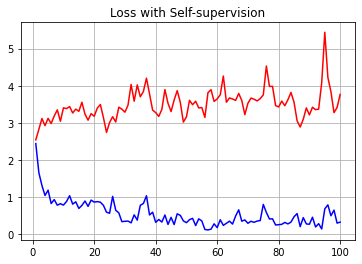

Max accuracy: 30.70


In [ ]:
model = SesemiNet(len(sup_classes), len(unsup_classes), pretrained=True)

sup_criterion = nn.CrossEntropyLoss()
unsup_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

unsup_train_losses, unsup_val_losses, unsup_val_accs = train(
    model,
    labeled_trainloader,
    unlabeled_trainloader,
    valloader=testloader,
    n_epochs=n_epochs,
    n_batches_print=n_batches_print)

plot_losses(unsup_train_losses, unsup_val_losses, title='Loss with Self-supervision')
print(f'Max accuracy: {np.max(unsup_val_accs):.2f}')

| Model | Number of  epochs  | Train accuracy | Test accuracy |Full data accuracy |
|------|------|------|------|------|
|   Resnet18(semi-supervised)  | 100 | 100% | 30.70% |----|
